In [2]:
#!/usr/bin/env python2
import os
import sys
import argparse
import time
from distutils.dir_util import copy_tree


import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import binary_crossentropy

from iterator import Iterator
import autoencoder_model as ae_model

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline



_FLOATX = config.floatX


Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/u/larocste/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
exp_name = 'AE_notebook_lr=0.01_wd=0_bs=512_conv=[2, 2, 2]_nfilt=32_code=750'
exp_name = 'AE_lr=0.01_wd=0_bs=512_conv=[2, 2, 2]_nfilt=32_code=500_nemax=500'


#Training hyper-parameters
learning_rate = 0.01
weight_decay = 0
num_epochs = 500
max_patience = 100
#data_augmentation={}

batch_size = 512
extract_center = True
load_caption = False
#nb_discriminator_steps = 2

#Model Hyperparameters
conv_before_pool=[2,2,2]
n_filters = 32                      
code_size = 500
filter_size = 3
pool_factor = 2






In [4]:
#######################
#Build dataset iterator
#######################

print "Loading training data..." #threads???
train_iter = Iterator(which_set='train', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

print "Loading validation data..." #threads???
valid_iter = Iterator(which_set='valid', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

test_iter = None



n_batches_train = train_iter.n_batches
n_batches_valid = valid_iter.n_batches
n_batches_test = test_iter.n_batches if test_iter is not None else 0

print "Batch. train: %d, val %d, test %d" % (n_batches_train,
                            n_batches_valid, n_batches_test)


def extract_batch(batch):
    inputs, targets, caps = batch
    inputs = np.transpose(inputs, (0,3,1,2))
    targets = np.transpose(targets, (0,3,1,2))
    
    return inputs, targets, caps

Loading training data...
Loading validation data...
Batch. train: 161, val 79, test 0


In [5]:
SAVEPATH = '/u/larocste/ift6266_project/save_models/' 
LOADPATH = '/u/larocste/ift6266_project/load_models/'
WEIGHTS_PATH = LOADPATH


#/u/larocste/ift6266_project/load_models/AE_notebook_lr=0.01_wd=0_bs=512_conv=[2, 2, 2]_nfilt=32_code=750

weight_path = os.path.join(WEIGHTS_PATH,  exp_name, 'ae_model_best.npz')

In [6]:
ae_input_var = T.tensor4('input var')
ae_target_var = T.tensor4('target var')

In [7]:
print 'Building model'
ae, last_layer = ae_model.AE_contour2center().build_network(input_var = ae_input_var,
                                              conv_before_pool=conv_before_pool,
                                              n_filters = n_filters,
                                              code_size = code_size,
                                              filter_size = filter_size,
                                              pool_factor = pool_factor)

print 'Assigning weights'
with np.load(weight_path) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    
nlayers = len(lasagne.layers.get_all_params(ae[last_layer]))
lasagne.layers.set_all_param_values(ae[last_layer], param_values[:nlayers])

print 'Done'



In [10]:
print "Defining and compiling test functions"

test_pred_imgs = lasagne.layers.get_output(ae[last_layer],deterministic=True)
test_loss = T.mean(lasagne.objectives.squared_error(test_pred_imgs, ae_target_var)) 
ae_test_fn = theano.function([ae_input_var, ae_target_var], test_loss, allow_input_downcast=True)

print "Defining get images function"

get_imgs = theano.function([ae_input_var], lasagne.layers.get_output(ae[last_layer],deterministic = True),
                          allow_input_downcast=True)

print 'Done'

Defining and compiling test functions
Defining get images function
Done


In [11]:
def test_and_plot(batch, subset=15, title = 'Ground truth, input var and generated image'):
    inputs, targets, caps = batch
    #inputs and targets already transposed for computation
    #must be retranspose for visualization
    if inputs.shape[0]==subset:
        indices = [i for i in range(subset)]
    else:
        indices = np.random.randint(inputs.shape[0], size=subset)
    plt.figure(dpi=subset*15)
    plt.title(title)
    for i in range(subset):

        idx = indices[i]

        fake_imgs = get_imgs(inputs[idx:idx+1])

        #True and generated center
        target_center = np.transpose(targets[idx], (1,2,0))
        fake_center = np.transpose(fake_imgs[0], (1,2,0))

        #Contour 
        input_contour = np.transpose(inputs[idx],(1,2,0))
        
        #True image (with center)
        full_img=np.zeros((64,64,3))
        np.copyto(full_img,input_contour)
        full_img[16:48,16:48, :] = target_center

        #Fake image (with generated center)
        full_fake_img = np.zeros((64,64,3))
        np.copyto(full_fake_img, input_contour)
        full_fake_img[16:48,16:48, :] = fake_center


        plot_image = np.concatenate((input_contour, full_img,full_fake_img), axis=0)
        if i==0:
            all_images = plot_image
        else:
            all_images = np.concatenate((all_images, plot_image), axis = 1)
        #plt.imshow(plot_image)

    plt.axis('off')
    plt.imshow(all_images)  
    plt.show()






In [13]:
def get_test_error(test_iter, plot_results = False):
    # Initialization

    err_test = 0
    start_time = time.time()


    #max_batches = test_iter.n_batches


    for i, test_batch in enumerate(test_iter):
#         if i>max_batches :
#             break

        test_batch = extract_batch(test_batch)
        inputs_test, targets_test, caps_test = test_batch
        cost_test_batch = ae_test_fn(inputs_test, targets_test)
        err_test += cost_test_batch
        
    if plot_results: #from last minibatch
        test_and_plot(test_batch)

    #Add epoch results 
    err_test = err_test/test_iter.n_batches

    #Print results (once per epoch)
    out_str = "Avg cost test %f, took %f s"
    out_str = out_str % (err_test, time.time()-start_time)
    print out_str
    print exp_name






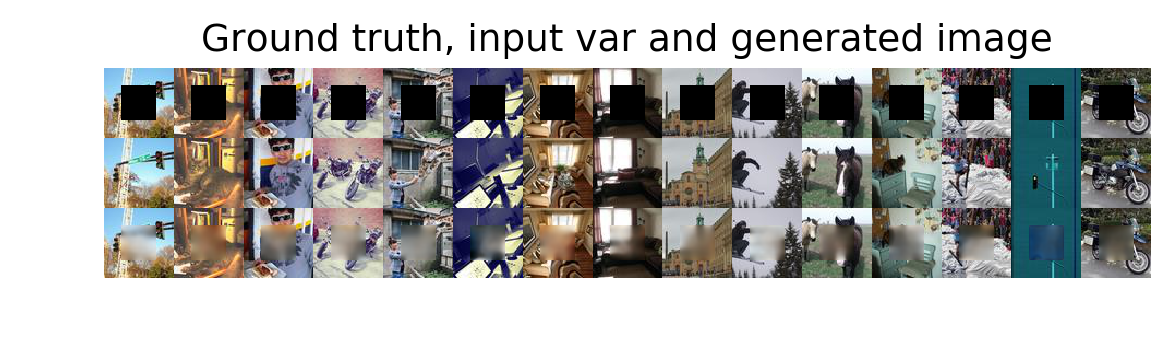

Avg cost test 0.034298, took 64.404873 s
AE_lr=0.01_wd=0_bs=512_conv=[2, 2, 2]_nfilt=32_code=500_nemax=500


In [14]:
get_test_error(valid_iter, plot_results=True)

In [15]:
a, b, c = extract_batch(valid_iter[:])

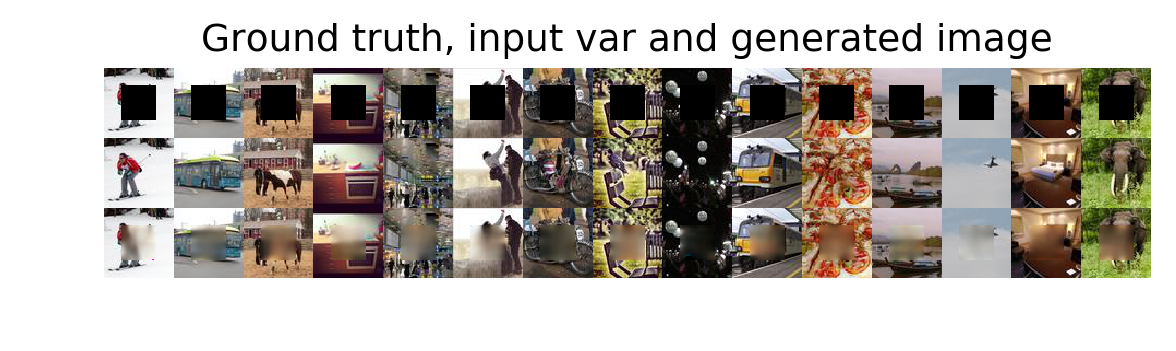

In [20]:

test_and_plot(extract_batch(valid_iter[3000:3100]))

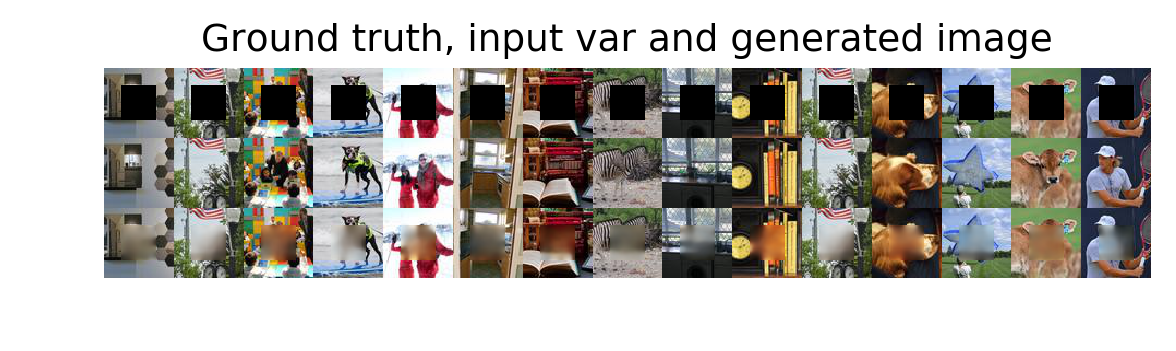

In [21]:
test_and_plot(extract_batch(train_iter[4000:4100]))

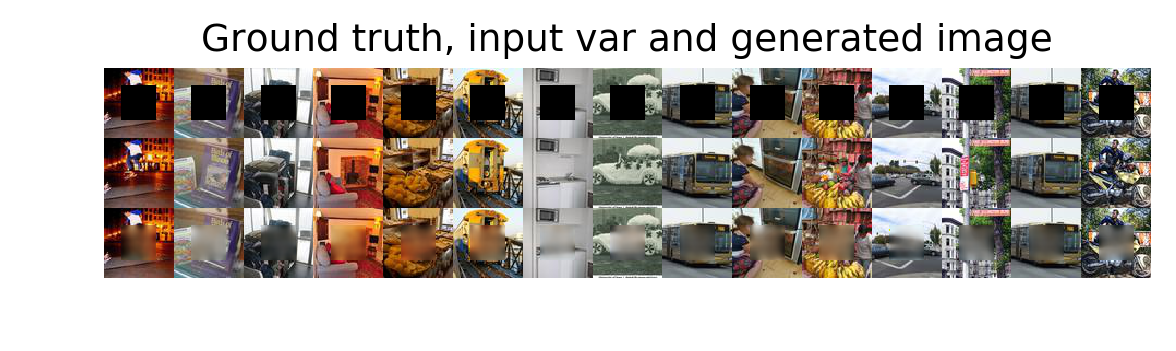

In [47]:


test_and_plot(extract_batch(valid_iter[1000:1500]))